# Thinking about hosting on Airbnb? Here's the secret sauce to success

## Business questions:

1. Who are the hosts? 
  
2. Can hosting generate decent income?
  
3. Any tips to become a successful host?

## Datasets

Source: *Seattle Airbnb Open Data: https://www.kaggle.com/airbnb/seattle/data#reviews.csv*

1. Listings:
  - 3818 rows, each row is an Airbnb listing in Seattle
  - 92 features such as textual descriptions, address, average review score, etc

1. Reviews
  - 84849 rows, each row is a review from a traveller
  - 6 features such as unique id for each reviewer, detailed comments, etc

1. Calendar
  - 1393570 rows, each row is the daily availability of a listing
  - 4 features such as availability, price , etc

## Importing Libraries needed

In [284]:
# Basic tools
import pandas as pd 
import scipy.stats as ss
import numpy as np
from pandas_profiling import ProfileReport
from collections import Counter
from pprint import pprint

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import geopy.distance


# Models
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
sns.set()
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('mode.chained_assignment', None)

## Defining some helper functions

In [285]:
def remove_constant_col(df):
    '''
    Identify then remove factors that have constant vlaues. 
    '''
    ct = 0
    for col in df.columns:
        uni_count = len(df[col].unique())
        nul_count = df[col].isnull().sum()
        nul_perc = nul_count/df.shape[0]
        if (uni_count == 1):
            df.drop(col,axis=1,inplace=True)
            print('{} removed.'.format(col))
            ct+=1
    print('Done. Total of {} columns were removed because they have constant values.'.format(ct))
    return df

def find_correlated_col(df):
    '''
    Identify pairs of factors that have higher than 90% of Pearson correlation. 
    '''
    corr_matrix = df.corr().abs()
    high_corr_var = np.where(corr_matrix>0.9)
    high_corr_var = [(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
    print(high_corr_var)
    print('Done. Found {} pairs of columns that have above 0.9 correlations.'.format(len(high_corr_var)))
    
def binary_encoding(series,amenity_keyword):
    '''
    For a cell value of a given column, if the cell contains 
    keyword of a specific amenity, then it is replaced with 1. 
    Otherwise, it is replaced with 0. 
    '''
    series_encoded = np.where(
        series.str.contains(amenity_keyword,case=False),
        1,
        0
    )
    return series_encoded

def get_unique(series):
    '''
    - Get unique amenities names of each listing. 
    - Count total number of each amenity across all listings. 
    '''
    ver_method = []
    listing_no = []
    line_count = 0
    for listing in series.str.split(','):
        line_count +=1
        try:
            for ver in listing:
                ver_method.append(ver)
        except:
                ver_method.append('n/a')
                listing_no.append(line_count)
    print('Total of {} unique values: '.format(len(set(ver_method))))
    print(Counter(ver_method))
    
    return Counter(ver_method)
    

def convert_to_binary(series):
    '''
    For a cell value of a given column, if the cell is null,
    then it is replaced with 0. Otherwise, it is replaced 
    with 1. 
    '''
    series= np.where(series.isnull()==False, 1, 0)
    return series

def format_dollar_str(series,df):
    '''
    Change dollar amount from string to float.
    '''
    df[series] = df[series].str.replace(r'\.00','')
    df[series] = df[series].str.replace(r'[,\$]','')
    df[series] = df[series].astype(float)
    
    return df[series]

def format_timestamp(series,df):
    '''
    - Change string to timestamp. 
    - Get days elapsed since last_day which is when the Seattle 
    datasets were collected.
    '''
    df[series] = pd.to_datetime(df[series])
    df[series] = last_day - df[series]
    df[series] = df[series].dt.days
    
    return df[series]

def clean_text(df,series):
    '''
    Conduct some simple text pre-processing on the listing description
    and guest reviews. 
    '''
    df[series] = df[series].str.replace(r"[^A-Za-z0-9^,!?\.\/'+&]", " ")
    df[series] = df[series].str.replace(r"\+", " plus ")
    df[series] = df[series].str.replace(r",", " ")
    df[series] = df[series].str.replace(r"\.", " ")
    df[series] = df[series].str.replace(r"!", " ! ")
    df[series] = df[series].str.replace(r"\?", " ? ")
    df[series] = df[series].str.replace(r"'", " ")
    df[series] = df[series].str.replace(r":", " : ")
    df[series] = df[series].str.replace(r"\s{2,}", " ")
    df[series] = df[series].str.lower()
    
    return df[series]

## Loading the data

In [286]:
listings = pd.read_csv('listings.csv')
listings.dropna(subset=['host_name'],axis=0,inplace=True)
listings.last_scraped = pd.to_datetime(listings.last_scraped)
last_listing = listings.last_scraped.max()
listings.sample(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
864,1772119,https://www.airbnb.com/rooms/1772119,20160104002432,2016-01-04,"Cherry Hill Cozy, Budget Loft-Bed",Our comfy double-bed loft is priced right ...,"Our truly, central home is grand in scale--we ...",Our comfy double-bed loft is priced right ...,none,"One of Seattle's oldest neighborhoods, the Cen...",Little extra's your chef and beer expert hosts...,Central area says it all: central to everythin...,https://a2.muscache.com/ac/pictures/27792742/e...,https://a2.muscache.com/im/pictures/27792742/e...,https://a2.muscache.com/ac/pictures/27792742/e...,https://a2.muscache.com/ac/pictures/27792742/e...,9555890,https://www.airbnb.com/users/show/9555890,Melissa,2013-10-21,"Seattle, Washington, United States",Hi world! We are Melissa and Abil. We have bee...,within a few hours,100%,100%,t,https://a2.muscache.com/ac/users/9555890/profi...,https://a2.muscache.com/ac/users/9555890/profi...,Minor,5.00,5.00,"['email', 'phone', 'reviews', 'jumio']",t,t,"19th Avenue, Seattle, WA 98122, United States",Minor,Minor,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.61,-122.31,t,House,Private room,2,2.00,1.00,1.00,Real Bed,"{""Wireless Internet"",Kitchen,""Free Parking on ...",nan,$58.00,$430.00,NaN,$200.00,$30.00,1,$0.00,2,29,a week ago,t,17,47,77,342,2016-01-04,68,2013-12-30,2015-11-29,100.00,10.00,10.00,10.00,10.00,10.00,10.00,f,nan,WASHINGTON,f,strict,f,f,5,2.77
3345,3959460,https://www.airbnb.com/rooms/3959460,20160104002432,2016-01-04,upper level apt in duplex with view,"Sunny in seattle is possible, this space has h...",Open floor plan in upper unit of duplex. Couch...,"Sunny in seattle is possible, this space has h...",none,"Walk to restaurants, pubs, groceries, librarie...",LGBT friendly space - No judgement household. ...,There are two bus routes close by. The 5 (mean...,https://a1.muscache.com/ac/pictures/50511043/5...,https://a1.muscache.com/im/pictures/50511043/5...,https://a1.muscache.com/ac/pictures/50511043/5...,https://a1.muscache.com/ac/pictures/50511043/5...,7307064,https://www.airbnb.com/users/show/7307064,Beth,2013-07-05,"Seattle, Washington, United States",seattle washington - purveyor of life inspirat...,within a day,86%,100%,t,https://a2.muscache.com/ac/users/7307064/profi...,https://a2.muscache.com/ac/users/7307064/profi...,NaN,1.00,1.00,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"North 70th Street, Seattle, WA 98103, United S...",NaN,Phinney Ridge,Other neighborhoods,Seattle,WA,98103,Seattle,"Seattle, WA",US,United States,47.68,-122.35,t,Apartment,Entire home/apt,4,1.00,1.00,2.00,Real Bed,"{TV,Internet,""Wireless Inter

In [287]:
last_listing

Timestamp('2016-01-04 00:00:00')

In [288]:
listings.shape

(3816, 92)

In [289]:
reviews = pd.read_csv('reviews.csv')
reviews.date = pd.to_datetime(reviews.date)
last_reviews = reviews.date.max()
reviews.sample(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
4239,392779,6199062,2013-08-03,7307995,Susan,The apartment was SPOTLESS. Jyoti was very gra...
23436,6278191,42289915,2015-08-12,2350816,Ryan,Carlos' apartment was a great place to stay wh...


In [290]:
last_reviews

Timestamp('2016-01-03 00:00:00')

In [291]:
reviews['last_12_month'] = np.where(
    reviews.date.dt.year.isin([2016, 2015]),
    1,
    0
)
reviews['last_12_month'].value_counts()

1    52716
0    32133
Name: last_12_month, dtype: int64

In [292]:
calendar = pd.read_csv('calendar.csv')
calendar.price = calendar.price.str.replace(r'\.00','')
calendar.price = calendar.price.str.replace(r'[$,]','')
calendar.price = calendar.price.astype(float) 
calendar.date = pd.to_datetime(calendar.date)
last_day = pd.to_datetime(calendar.date.max())
calendar.sample(2)

,listing_id,date,available,price
494181,8027776,2016-12-05,f,nan
535371,3891695,2016-10-11,f,nan


In [293]:
 calendar.shape

(1393570, 4)

In [294]:
calendar.date.max()

Timestamp('2017-01-02 00:00:00')

## Pre-processing

In [295]:
listings = remove_constant_col(listings)

scrape_id removed.
last_scraped removed.
experiences_offered removed.
market removed.
country_code removed.
country removed.
has_availability removed.
calendar_last_scraped removed.
requires_license removed.
license removed.
jurisdiction_names removed.
Done. Total of 11 columns were removed because they have constant values.


In [296]:
reviews = remove_constant_col(reviews)

Done. Total of 0 columns were removed because they have constant values.


In [297]:
calendar = remove_constant_col(calendar)

Done. Total of 0 columns were removed because they have constant values.


In [298]:
find_correlated_col(listings)

[('host_listings_count', 'host_total_listings_count'), ('availability_30', 'availability_60'), ('availability_60', 'availability_90')]
Done. Found 3 pairs of columns that have above 0.9 correlations.


In [299]:
listings.drop('host_total_listings_count',axis=1,inplace=True)

In [300]:
find_correlated_col(reviews)

[]
Done. Found 0 pairs of columns that have above 0.9 correlations.


In [301]:
find_correlated_col(calendar)

[]
Done. Found 0 pairs of columns that have above 0.9 correlations.


^ host_listings_count and host_total_listings_count are basically identical except 2 nulls. Simply removing 1 of them. availability_30, 60, and 90 are sort of expected to have high correlation, so keeping them all for now.

In [302]:
# removing columns of urls and non-helpful values such as state and city
listings = listings[listings.columns[listings.columns.str.contains('url')==False]]
listings = listings.drop([
    'city',
    'host_acceptance_rate',
    'smart_location',
    'state'
],axis=1)

## Null values handling 

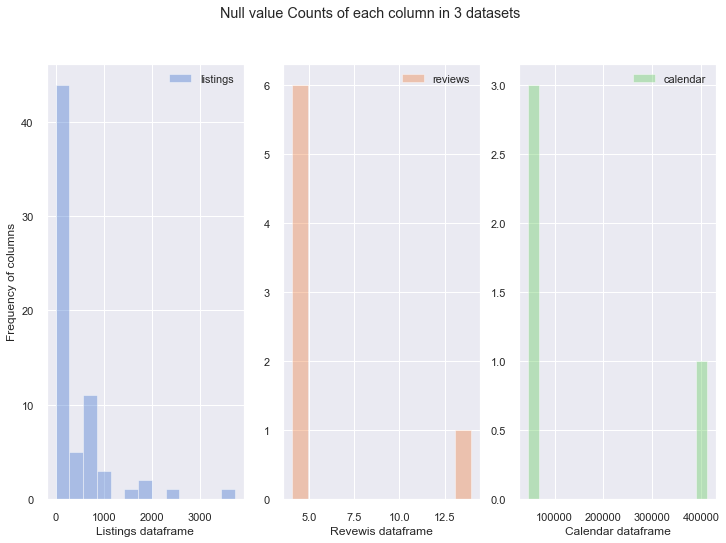

In [303]:
sns.set();
f, axes = plt.subplots(1, 3, figsize=(12, 8), sharex=False, sharey=False)

listings_null_row = listings.isnull().sum()
reviews_null_row = reviews.isnull().sum()
calendar_null_row = calendar.isnull().sum()

color_palette_list = sns.color_palette('muted')
hist_kws={
        "rwidth":0.15
    }

sns.distplot(
    listings_null_row,
    kde=False,
    rug=False,
    ax=axes[0],
    color=color_palette_list[0], 
    label = 'listings'
)
sns.distplot(
    reviews_null_row, 
    kde=False,
    rug=False,
    ax=axes[1],
    color=color_palette_list[1],
    label = 'reviews',
    hist_kws={
        "rwidth":0.1
    }
)
sns.distplot(
    calendar_null_row, 
    kde=False,
    rug=False,
    ax=axes[2],
    color=color_palette_list[2], 
    label = 'calendar',
    hist_kws={
        "rwidth":0.2
    }
)

axes[0].set_xlabel('Listings dataframe')
axes[1].set_xlabel('Revewis dataframe')
axes[2].set_xlabel('Calendar dataframe')
axes[0].set_ylabel('Frequency of columns')

axes[0].legend()
axes[1].legend()
axes[2].legend()

f.suptitle('Null value Counts of each column in 3 datasets');

In [304]:
listings.isnull().sum()[listings.isnull().sum()>0].sort_values(ascending=False)

square_feet                    3719
monthly_price                  2300
security_deposit               1950
weekly_price                   1809
notes                          1605
neighborhood_overview          1031
cleaning_fee                   1029
transit                         933
host_about                      857
review_scores_checkin           656
review_scores_accuracy          656
review_scores_value             654
review_scores_location          653
review_scores_cleanliness       651
review_scores_communication     649
review_scores_rating            645
reviews_per_month               625
first_review                    625
last_review                     625
space                           568
host_response_rate              521
host_response_time              521
neighbourhood                   416
host_neighbourhood              298
summary                         177
bathrooms                        16
zipcode                           7
host_location               

In [305]:
# Droppng square_feet because of too many nulls 
listings.drop('square_feet',axis=1,inplace=True)

In [306]:
# Assuming null values for 'security_deposit','cleaning_fee' means no charges
listings[['security_deposit','cleaning_fee']] = listings[['security_deposit','cleaning_fee']].fillna(value='$0')

In [307]:
# Converting columns that have above 700 nulls to binary.
to_bina = listings.isnull().sum()[listings.isnull().sum()>700]
for col in to_bina.index.values:
    listings[col] = convert_to_binary(listings[col])

In [308]:
# Identify low cardinal columns 
# Transfering binary columns that are nomimal to numeric

listings_temp = listings.copy()
low_cardinality_col = []
binary_col = []
for col in listings_temp.columns:
    unique_count = len(listings[col].unique())
    if 2 < unique_count < 10:
        low_cardinality_col.append(col)
    if unique_count == 2:
        binary_col.append(col)
    
listings_temp.dtypes.value_counts()

object     35
int64      18
float64    14
dtype: int64

In [309]:
# Taking a closer look at nulls due to no reviews recorded 
review_col = listings.columns[listings.columns.str.contains('review')]
listings[listings.number_of_reviews==0][review_col].drop(
    ['number_of_reviews'],axis=1).isnull().sum()

first_review                   625
last_review                    625
review_scores_rating           625
review_scores_accuracy         625
review_scores_cleanliness      625
review_scores_checkin          625
review_scores_communication    625
review_scores_location         625
review_scores_value            625
reviews_per_month              625
dtype: int64

In [310]:
listings = listings[listings.number_of_reviews!=0]
listings.reset_index(drop=True,inplace=True)

In [311]:
# fill na for response_time and rate
listings.host_response_time = listings.host_response_time.fillna('never')
listings.host_response_rate = listings.host_response_rate.fillna('0%')
listings.host_response_rate = listings.host_response_rate.str.extract(r'(\d+)\%')

In [312]:
# simply fill na with strings for the 2 textual features
simply_fill = [
    'space',
    'summary',
    'neighbourhood',
    'host_neighbourhood',
    'host_location',
    'zipcode',
    ]
listings[simply_fill] = listings[simply_fill].fillna(value='n/a')

In [313]:
listings.isnull().sum()[listings.isnull().sum()>0].sort_values(ascending=False)

review_scores_checkin          31
review_scores_accuracy         31
review_scores_value            29
review_scores_location         28
review_scores_cleanliness      26
review_scores_communication    24
review_scores_rating           20
bathrooms                      12
bedrooms                        6
dtype: int64

In [314]:
# Impute the only listing without property_type w/ most common value
listings.property_type = listings.property_type.fillna('House')

# Impute the rest numberical columns with means
to_impute = listings.isnull().sum()[listings.isnull().sum()>0].sort_values(ascending=False).index

imp_mode = SimpleImputer(missing_values=np.nan, strategy='mean')
listings_imputed = pd.DataFrame(imp_mode.fit_transform(listings[to_impute]))

listings_imputed.columns = listings[to_impute].columns
listings_imputed.index = listings[to_impute].index
for x in listings[to_impute].columns:
    listings_imputed[x]=listings_imputed[x].astype(listings[to_impute][x].dtypes.name)
listings[to_impute] = listings_imputed
listings_imputed = listings.copy()
listings_imputed.shape,listings.shape

((3191, 67), (3191, 67))

In [315]:
# Imputing null price with its average price in 2016 
calendar_imputed = calendar.copy()
calendar_imputed["price"] = calendar_imputed.groupby("listing_id").transform(lambda x: x.fillna(x.mean()))

# For listings that shown as avaliable throughout 2016, imputing their prices 
# with the average price of the Seatle region  
calendar_imputed["price"].fillna(calendar_imputed.price.mean(),inplace=True)
calendar_imputed.sample(5)

,listing_id,date,available,price
489259,8815638,2016-06-11,f,182.72
287380,585418,2016-05-08,t,59.00
1326341,7824426,2016-10-26,t,85.00
985969,338043,2016-04-17,t,200.00
134903,3193738,2016-08-09,t,150.00


In [316]:
# Null handelling is done for listing dataset
listings_imputed.isnull().sum().value_counts()

0    67
dtype: int64

In [317]:
# Null handelling is done for reviews dataset
reviews_imputed = reviews.fillna('n/a')
reviews_imputed.isnull().sum().value_counts()

0    7
dtype: int64

In [318]:
# Null handelling is done for calendar dataset
calendar_imputed.isnull().sum().value_counts()

0    4
dtype: int64

## Additional pre-processing

In [319]:
# Count the total reviews of last 365 days of each listing
# Revoming listings that didn't have any review in past 365 days
listing_review_365_dict = reviews_imputed[reviews_imputed.last_12_month==1].groupby('listing_id').size()
listings_imputed = listings_imputed[listings_imputed.id.isin(listing_review_365_dict.index)]
listing_review_365_dict = listing_review_365_dict.rename('id')
listing_review_365_dict = dict(listing_review_365_dict)
listings_imputed['reviews_365'] = listings_imputed.replace({"id" : listing_review_365_dict}).id
listings_imputed = listings_imputed[listings_imputed.reviews_365>=0]

In [320]:
# It seems the number_of_reviews is the accumulative reviews of listings
(listings_imputed['reviews_365'] == listings_imputed.number_of_reviews).value_counts()

True     1943
False    1168
dtype: int64

In [321]:
listings_imputed.amenities = listings_imputed.amenities.replace('{}',np.nan)
listings_imputed.amenities =listings_imputed.amenities.str.replace(r'[\{\}"]', '')
amentities_counter = get_unique(listings_imputed.amenities)

listings_imputed['amenities_counts'] = listings_imputed.amenities.str.split(',').str.len()
listings_imputed['amenities_counts'] = listings_imputed['amenities_counts'].fillna(0)

# survey shows the following are the most wanted amenties in the US (2)
most_wanted_amenities= [
    'Air Conditioning',
    'Free Parking on Premises',
    'Pets Allowed',
    'pool',
    'Kitchen'
]

# encoding the non nulls to 1 and nulls to 0 
for ame in most_wanted_amenities:
     listings_imputed[ame]= binary_encoding(listings_imputed.amenities,ame)

listings_imputed.drop('amenities',axis=1,inplace=True)

listings_imputed.host_verifications = listings_imputed.host_verifications.str.replace(r"[\[\]']", '').str.replace(r', ',',').replace(r'None',np.nan).replace('',np.nan)
host_verifications_counter = get_unique(listings_imputed.host_verifications)

listings_imputed['host_verifications_counts'] = listings_imputed.host_verifications.str.split(',').str.len()
listings_imputed['host_verifications_counts'] = listings_imputed['host_verifications_counts'].fillna(0)

established_verifications = [
    'kba',
    'jumio'
]

# encoding the non nulls to 1 and nulls to 0 
for host_v in established_verifications:
     listings_imputed[host_v]= binary_encoding(listings_imputed.host_verifications,host_v)

listings_imputed.drop('host_verifications',axis=1,inplace=True)

Total of 42 unique values: 
Counter({'Wireless Internet': 3022, 'Heating': 2987, 'Kitchen': 2806, 'Smoke Detector': 2732, 'Essentials': 2696, 'Dryer': 2441, 'Washer': 2433, 'Internet': 2340, 'Shampoo': 2259, 'TV': 2105, 'Carbon Monoxide Detector': 2098, 'Fire Extinguisher': 1832, 'Free Parking on Premises': 1795, 'Family/Kid Friendly': 1638, 'First Aid Kit': 1410, 'Cable TV': 1195, 'Pets live on this property': 739, 'Indoor Fireplace': 723, 'Elevator in Building': 637, 'Hangers': 633, 'Safety Card': 613, 'Hair Dryer': 603, 'Iron': 579, 'Air Conditioning': 555, 'Laptop Friendly Workspace': 545, '24-Hour Check-in': 459, 'Buzzer/Wireless Intercom': 448, 'Dog(s)': 422, 'Pets Allowed': 384, 'Gym': 352, 'Cat(s)': 322, 'Wheelchair Accessible': 251, 'Hot Tub': 245, 'Breakfast': 244, 'Suitable for Events': 177, 'Pool': 138, 'Smoking Allowed': 67, 'Doorman': 65, 'Lock on Bedroom Door': 53, 'Other pet(s)': 44, 'n/a': 22, 'Washer / Dryer': 1})
Total of 14 unique values: 
Counter({'reviews': 3107, 

In [322]:
# Transforming timestamp str to days in interger 
listings_imputed['host_since'] =  format_timestamp('host_since',listings_imputed)
listings_imputed['first_review'] =  format_timestamp('first_review',listings_imputed)
listings_imputed['last_review'] =  format_timestamp('last_review',listings_imputed)

# Transforming dollar amount str to interger 
for col in listings_imputed.select_dtypes('object').columns:
    dollar_sign_count = listings_imputed[col].str.contains(r'\$\d+').sum()
    if dollar_sign_count == listings_imputed.shape[0]:
        listings_imputed[col] = format_dollar_str(col,listings_imputed)

# Dropping the price column from listing dataframe because we alreay have it 
listings_imputed.drop('price',axis=1,inplace=True)

# Changing the possible typo of the zipcode  
listings_imputed.zipcode = listings_imputed.zipcode.str.replace('99\n98122','98122')

In [323]:
# Obtained common firstname and likeliyhood of gender associated from (1)
name_gender = pd.read_csv('name_gender.csv')
name_gender.gender.replace(
    {
        "M":0,
        "F":1
    },inplace=True
)
name_gender_dict = dict(zip(name_gender.name, name_gender.gender))
name_gender.head(2) 

,name,gender,probability
0,Aaban,0,1.00
1,Aabha,1,1.00


In [324]:
listings_imputed.host_name = listings_imputed.host_name.str.replace(r'\-|&|\+',',')
listings_imputed.host_name = listings_imputed.host_name.str.replace(r'\bAnd\b',',')
listings_imputed.host_name = listings_imputed.host_name.str.replace(r'([a-z])/([a-zA-z])','\1,\2')
listings_imputed.host_name = listings_imputed.host_name.str.replace('[\(\)]','')
listings_imputed.host_name = listings_imputed.host_name.str.replace(r'\s+',' ')
listings_imputed.host_name = listings_imputed.host_name.str.replace(r'\s?,\s?',',')
listings_imputed['host_count'] = [len(name) for name in listings_imputed.host_name.str.split(',')]


listings_imputed['gender'] = listings_imputed.replace({"host_name" : name_gender_dict}).host_name
listings_imputed['gender'] = np.where(
    listings_imputed.gender.isin([0,1])==False,
    'unknown',
    listings_imputed.gender
)
listings_imputed = listings_imputed.join(pd.get_dummies(listings_imputed['gender'],prefix='gender'))
listings_imputed.rename(
    {
        'gender_0' : 'male_host',
        'gender_1' : 'female_host',
        'gender_unknown' : 'gender_unknown'
    },inplace=True,axis=1
)
listings_imputed.drop('gender',axis=1,inplace=True)

listings_imputed['host_in_seattle'] = np.where(
    listings_imputed.host_location.str.contains('Seattle',case=False),
    1,
    0
)

In [325]:
# Found 1 host apear to be a commerical rental company
listings_imputed[listings_imputed.host_name=='Sea To Sky Rentals'].shape

(29, 79)

In [326]:
# mapping hosts to listings with info of NO. of nights available
grouped_listing = calendar_imputed.groupby(['listing_id','available']).price.value_counts()
temp = grouped_listing[grouped_listing.index.isin(['f'], level=1)]
performance = pd.DataFrame(
    columns=['listing_id','nights_unavailable','nights_available','estimated_price'],
    data={
        'listing_id' : temp.index.get_level_values(0),
        'nights_unavailable' : temp.values,
        'nights_available' : 365 - temp.values,
        'estimated_price' : temp.index.get_level_values(2)
    }
    
)
performance = performance.merge(calendar_imputed,on='listing_id',how='inner').fillna(0).drop_duplicates(subset='listing_id')
performance.drop(['price','available','date'],axis=1,inplace=True)

# temp listing copy for inner join
listings_1 = listings_imputed.copy()
listings_1['listing_id'] = listings_1['id'].copy()
performance = performance.merge(listings_1[['host_id','listing_id']],on='listing_id',how='inner')

# calculating the estimated income of a listing 
performance['nights_available'] = performance['nights_available'].astype(int)
performance['estimated_price'] = performance['estimated_price'].astype(int)
performance = performance[[
    'listing_id',
    'host_id',
    'nights_unavailable', 
    'nights_available',
    'estimated_price',
]]
listings_imputed.rename({'id':'listing_id'},axis=1,inplace=True)
listings_performance = performance.merge(listings_imputed.drop('host_id',axis=1),on='listing_id',how='inner')

# according to airbnb about 72% (3) of guests eneded up leaving a review  
listings_performance['estimated_bookings'] = listings_performance.reviews_365 / 0.72
listings_performance['estimated_income'] = listings_performance['estimated_bookings'] * listings_performance['estimated_price']

listings_performance['host_in_wa'] = np.where(
    listings_performance.host_location.str.contains(r'seattle|Washington, United States|Washington State',case=False),
    1,
    0
)

pike_place = (47.609657, -122.342148)
listings_performance['lat_long'] = list(zip(listings_performance.latitude, listings_performance.longitude))
listings_performance['distance_from_pp'] = listings_performance.lat_long.apply(lambda x: geopy.distance.geodesic(pike_place, x).miles)

listings_performance.calendar_updated.replace(
    {
        'today' : '0 day ago',
        'yesterday' : '1 day ago',
        'a week ago' : '1 week ago',
    },inplace=True
)
listings_performance['calendar_updated_months'] = listings_performance.calendar_updated.str.extract(r'(.*)\s+months?').fillna(0).astype(int)
listings_performance['calendar_updated_weeks'] = listings_performance.calendar_updated.str.extract(r'(.*)\s+weeks?').fillna(0).astype(int)
listings_performance['calendar_updated_days'] = listings_performance.calendar_updated.str.extract(r'(.*)\s+days?').fillna(0).astype(int)
listings_performance['calendar_updated_count'] = listings_performance.calendar_updated_months*30 + listings_performance.calendar_updated_weeks*7 + listings_performance.calendar_updated_days
listings_performance['calendar_updated_count'] = np.where(
    listings_performance.calendar_updated=='never',
    listings_performance.host_since,
    listings_performance.calendar_updated_count
)

listings_performance['cancellation_policy'] = listings_performance['cancellation_policy'].replace(
    {
        'flexible':1, 
        'moderate':2,
        'strict':3
    }
)
listings_performance.sample(3)

,listing_id,host_id,nights_unavailable,nights_available,estimated_price,name,summary,space,description,neighborhood_overview,notes,transit,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,reviews_365,amenities_counts,Air Conditioning,Free Parking on Premises,Pets Allowed,pool,Kitchen,host_verifications_counts,kba,jumio,host_count,male_host,female_host,gender_unknown,host_in_seattle,estimated_bookings,estimated_income,host_in_wa,lat_long,distance_from_pp,calendar_updated_months,calendar_updated_weeks,calendar_updated_days,calendar_updated_count
951,4144767,430709,77,288,123,Ballard Cottage- Charming Tiny Home,This one of-a-kind studio home is conveniently...,"Perfect for one or two, this unique studio cot...",This one of-a-kind studio home is conveniently...,1,1,1,Sea To Sky Rentals,2127,"Seattle, Washington, United States",1,within a day,88,f,Belltown,36.00,t,t,"25th Ave NW and NW 67th St, Seattle, WA 98117,...",Ballard,Loyal Heights,Ballard,98117,47.68,-122.39,f,House,Entire home/apt,2,1.00,0.00,1.00,Real Bed,0,0,0.00,129.00,1,0.00,3,1125,0 day ago,18,28,33,288,5,586,475,84.00,9.00,9.00,8.00,9.00,8.00,8.00,f,3,t,t,31,0.67,5,13.00,0,1,0,0,1,6,0,1,1,0,0,1,1,6.94,854.17,1,"(47.67703164673482, -122.38978825845714)",5.16,0,0,0,0
1172,5021969,6372203,2,363,185,Pioneer Square Apartment 202,Historic one bedroom apartment with exposed br...,"One bedroom Apartment in Pioneer Square, Downt...",Historic one bedroom apartment with exposed br...,1,1,1,Darcy,1330,"Seattle, Washington, United States",1,within a few hours,99,f,Central Business District,7.00,t,t,"Yesler Way, Seattle, WA 98104, United States",Pioneer Square,Pioneer Square,Downtown,98104,47.60,-122.33,t,Apartment,Entire home/apt,3,1.00,1.00,2.00,Real Bed,0,0,300.00,0.00,1,0.00,1,1125,1 week ago,28,58,88,363,42,656,416,87.00,9.00,9.00,9.00,9.00,8.00,8.00,f,3,f,f,6,4.30,42,11.00,0,0,0,0,1,5,0,1,1,0,1,0,1,58.33,"10,791.67",1,"(47.601027874069274, -122.3346014585082)",0.69,0,1,0,7
1970,7557951,39607395,225,140,100,Historic Heart of Capitol Hill,Adorable 1 bd/1br vintage apartment located in...,Vintage 1920s apartment.,Adorable 1 bd/1br vintage apartment located in...,1,1,1,Elizabeth,526,"Seattle, Washington, United States",1,within a day,100,f,Capitol Hill,1.00,t,t,"East Harrison Street, Seattle, WA 98102, Unite...",Capitol Hill,Broadway,Capitol Hill,98102,47.62,-122.33,t,Apartment,Entire home/apt,3,1.00,1.00,2.00,Real Bed,0,0,200.00,20.00,3,20.00,1,1125,5 days ago,0,4,4,140,3,491,456,100.00,10.00,10.00,10.00,10.00,10.00,10.00,f,2,f,f,1,0.70,3,14.00,0,1,0,0,1,5,0,1,1,0,1,0,1,4.17,416.67,1,"(47.62266250007002, -122.32792901166654)",1.12,0,0,5,5


In [327]:
# calculate NO. of nights unavailable on host level across all listings owned
grouped = listings_performance.groupby('host_id')
hosts = pd.DataFrame(
    columns=[
        'listings_owned_in_seattle',
        'estimated_bookings',
        'estimated_income',
        'reviews_365'
    ],
    data={
        'listings_owned_in_seattle' : grouped.host_listings_count.size(),
        'estimated_bookings' : grouped.estimated_bookings.sum(),
        'estimated_income' : grouped.estimated_income.sum(),
        'reviews_365' : grouped.reviews_365.sum()
         }
)

hosts.reset_index(drop=False,inplace=True)
lp_to_join = listings_performance[[
    'host_id',
    'host_name',
    'host_since',
    'host_location',
    'host_about',
    'host_is_superhost',
    'host_neighbourhood',
    'host_listings_count',
    'host_has_profile_pic',
    'host_identity_verified',
    'male_host',
    'female_host',
    'gender_unknown',
    'host_count',
    'host_in_seattle'
]].drop_duplicates(subset='host_id')
hosts = hosts.merge(lp_to_join,on='host_id',how='inner')

tf_dict = {'f':0,'t':1}
hosts = hosts.replace({"host_is_superhost": tf_dict})
hosts = hosts.replace({"host_has_profile_pic": tf_dict})
hosts = hosts.replace({"host_identity_verified": tf_dict})

hosts['multiple_listings_owner'] = np.where(
    hosts.listings_owned_in_seattle > 1,
    1,
    0
)
hosts['reviews_365_per_listing'] = hosts.reviews_365 / hosts.listings_owned_in_seattle
hosts['host_listings_count_outside'] = np.where(
    hosts.host_listings_count != hosts.listings_owned_in_seattle,
    hosts.host_listings_count - hosts.listings_owned_in_seattle,
    0
)
hosts.sample(5)

,host_id,listings_owned_in_seattle,estimated_bookings,estimated_income,reviews_365,host_name,host_since,host_location,host_about,host_is_superhost,host_neighbourhood,host_listings_count,host_has_profile_pic,host_identity_verified,male_host,female_host,gender_unknown,host_count,host_in_seattle,multiple_listings_owner,reviews_365_per_listing,host_listings_count_outside
1509,26967583,21,488.89,"21,769.44",352,Dario,703,"Seattle, Washington, United States",1,0,University District,21.00,1,0,1,0,0,1,1,1,16.76,0.00
1229,18681876,1,25.00,"2,000.00",18,Margaret,895,"Seattle, Washington, United States",1,1,n/a,1.00,1,1,0,1,0,1,1,0,18.00,0.00
339,2373847,2,27.78,"1,358.33",20,"Lara,Ashley",1694,"Seattle, Washington, United States",1,0,North Delridge,2.00,1,1,0,0,1,2,1,1,10.00,0.00
1744,37373833,1,40.28,"2,859.72",29,"Minh,Chau",549,"Seattle, Washington, United States",1,1,Minor,1.00,1,1,0,0,1,2,1,0,29.00,0.00
196,1146836,1,56.94,"4,669.44",41,Mona,1939,"Seattle, Washington, United States",1,1,Eastlake,2.00,1,1,0,1,0,1,1,0,41.00,1.00


In [328]:
hosts.shape

(1959, 22)

## 1. Who are the hosts? 
- locations
- genders
- [co-hosts](https://www.airbnb.com/help/article/1243/whats-a-cohost)
- [superhosts staus](https://www.airbnb.com/superhost)
- number of properties owned in Seattle
- number of properties owned outside of Seattle

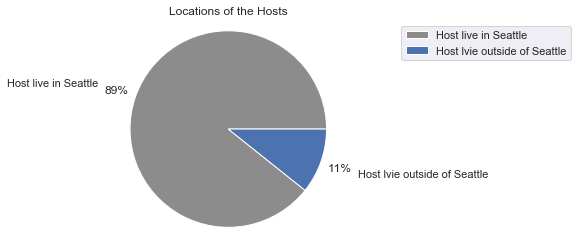

In [329]:
fig, ax = plt.subplots()
color_palette_list = sns.color_palette()
labels = ['Host live in Seattle', 
         'Host lvie outside of Seattle']
percentages = [
    hosts[hosts.host_in_seattle==1].shape[0]/hosts.shape[0], 
    1-hosts[hosts.host_in_seattle==1].shape[0]/hosts.shape[0]
]
explode=(0,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=[color_palette_list[7],color_palette_list[0]], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Locations of the Hosts")
ax.legend(frameon=True, bbox_to_anchor=(1,1));

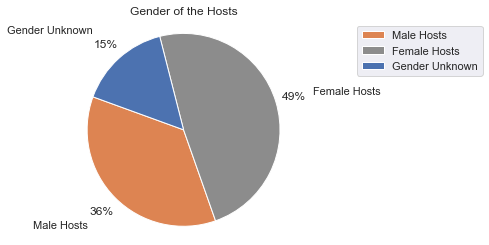

In [330]:
fig, ax = plt.subplots()
labels = [ 
    'Male Hosts',
    'Female Hosts',
    'Gender Unknown'
]
percentages = [
    hosts[hosts.male_host==1].shape[0]/hosts.shape[0], 
    hosts[hosts.female_host==1].shape[0]/hosts.shape[0],
    hosts[hosts.gender_unknown==1].shape[0]/hosts.shape[0],
]
explode=(0,0,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=[color_palette_list[1],color_palette_list[7],color_palette_list[0]], autopct='%1.0f%%', 
       shadow=False, startangle=160,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Gender of the Hosts")
ax.legend(frameon=True, bbox_to_anchor=(1,1));

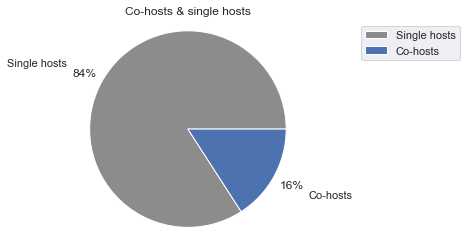

In [331]:
fig, ax = plt.subplots()
labels = [ 
    'Single hosts',
    'Co-hosts'
]
percentages = [
    hosts[hosts.multiple_listings_owner==0].shape[0]/hosts.shape[0], 
    hosts[hosts.multiple_listings_owner==1].shape[0]/hosts.shape[0]
]
explode=(0,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=[color_palette_list[7],color_palette_list[0]], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Co-hosts & single hosts")
ax.legend(frameon=True, bbox_to_anchor=(1,1));

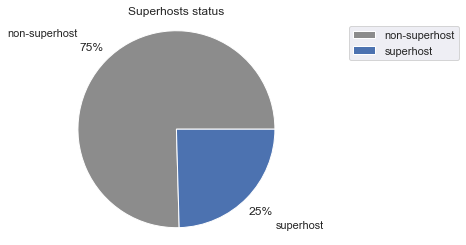

In [332]:
fig, ax = plt.subplots()
labels = ['non-superhost', 
         'superhost']
percentages = [
    hosts[hosts.host_is_superhost==0].shape[0]/hosts.shape[0], 
    1-hosts[hosts.host_is_superhost==0].shape[0]/hosts.shape[0]
]
explode=(0,0)
ax.pie(percentages, explode=explode, labels=labels,  
       colors=[color_palette_list[7],color_palette_list[0]], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.4)
ax.axis('equal')
ax.set_title("Superhosts status")
ax.legend(frameon=True, bbox_to_anchor=(1,1));

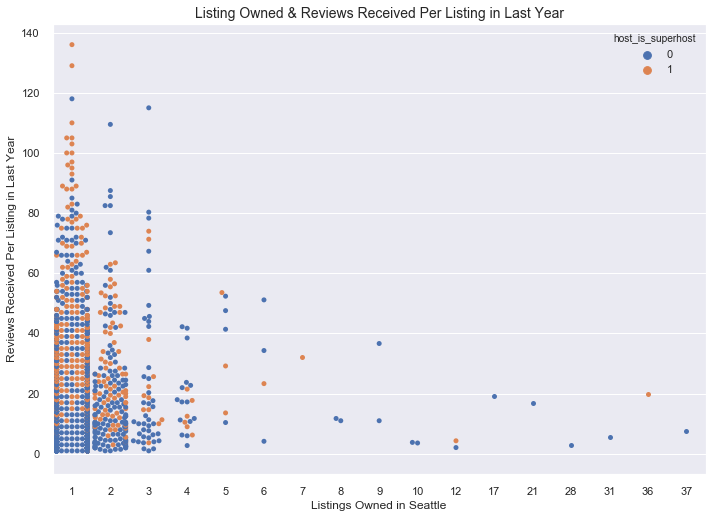

In [333]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
fig.set_size_inches(11.7, 8.27)
sns.swarmplot(
    x="listings_owned_in_seattle",
    y="reviews_365_per_listing",
    hue="host_is_superhost",
    data=hosts,
    ax=ax
)
ax.set_title('Listing Owned & Reviews Received Per Listing in Last Year', fontsize=14)
ax.set_ylabel('Reviews Received Per Listing in Last Year')
ax.set_xlabel('Listings Owned in Seattle');

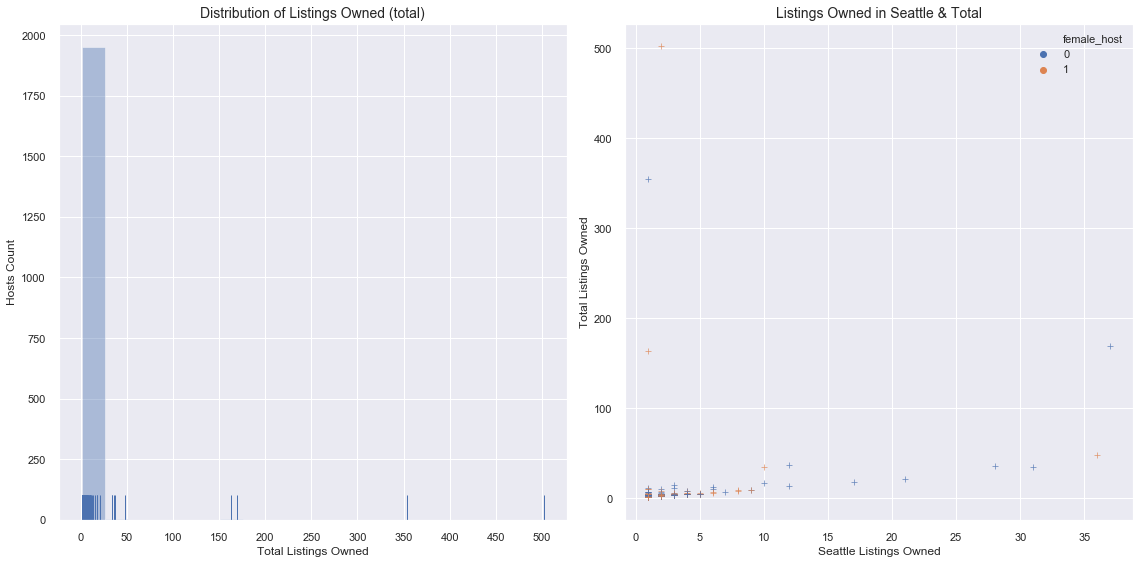

In [334]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.distplot(
    hosts['host_listings_count'],
    bins=20,
    rug=True,
    kde=False,
    ax=ax[0]   
)


sns.scatterplot(
    x="listings_owned_in_seattle", 
    y="host_listings_count", 
    data=hosts,
    hue='female_host',
    alpha=0.8,
    x_jitter=0.4,
    ax=ax[1],
    marker='+'
)

ax[0].set_xticks(range(0,525,50))
ax[0].set_title('Distribution of Listings Owned (total)', fontsize=14)
ax[0].set_ylabel('Hosts Count')
ax[0].set_xlabel('Total Listings Owned')

ax[1].set_title('Listings Owned in Seattle & Total', fontsize=14)
ax[1].set_ylabel('Total Listings Owned')
ax[1].set_xlabel('Seattle Listings Owned')
plt.tight_layout();

## 2. Can hosting generate decent income?

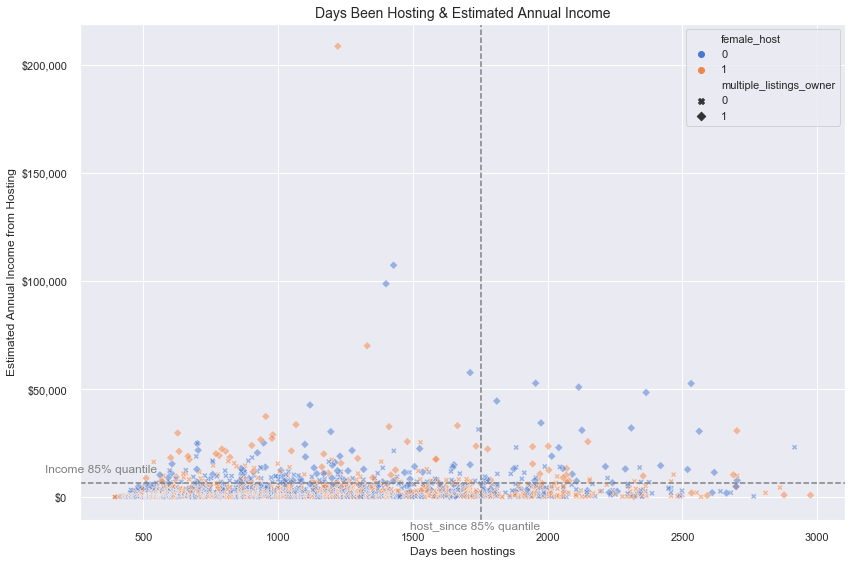

In [335]:
f, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=False, sharey=False)
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
markers = {0 : "X", 1 : "D"}

ax = sns.scatterplot(
    x="host_since",
    y="estimated_income",
    hue='female_host',
    style="multiple_listings_owner",
    markers=markers,
    data=hosts,
    x_jitter=.01,
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted"
)
ax.axhline(hosts.estimated_income.quantile(0.85), ls='--',color='gray')
ax.annotate(
    "Income 85% quantile", 
    xy=(0,0), 
    xycoords="axes fraction",
    xytext=(-35,47), 
    textcoords="offset points",
    color='gray'
           )
ax.axvline(hosts.host_since.quantile(0.85), ls='--',color='gray')
ax.annotate(
    "host_since 85% quantile", 
    xy=(0,0), 
    xycoords="axes fraction",
    xytext=(330,-10), 
    textcoords="offset points",
    color='gray'
           )
ax.legend(frameon=True, bbox_to_anchor=(1,1))
ax.set_title('Days Been Hosting & Estimated Annual Income', fontsize=14)
ax.set_xlabel('Days been hostings')
ax.set_ylabel('Estimated Annual Income from Hosting')
plt.tight_layout();

In [336]:
print(
    'In average,\n - hosts in Seattle Airbnb market made an estimated annual income of ${}.'.format(
        round(hosts.estimated_income.mean(),2)
    )
)

print(
    ' - top 85% made around ${}.'.format(
        round(hosts[hosts.estimated_income>=hosts.estimated_income.quantile(0.85)].estimated_income.mean(),2)
    )
)


print(
    ' - hosts who live in Seattle made around ${}.'.format(
        round(hosts[hosts.host_in_seattle==1].estimated_income.mean(),2)
    )
)

print(
    ' - female hosts made around ${}.'.format(
        round(hosts[hosts.female_host==1].estimated_income.mean(),2)
    )
)

print(
    ' - co-hosts made around ${}.'.format(
        round(hosts[hosts.host_count>1].estimated_income.mean(),2)
    )
)

print(
    ' - superhosts made around ${}.'.format(
        round(hosts[hosts.host_is_superhost==1].estimated_income.mean(),2)
    )
)


print(
    ' - hosts who own multiple listings made around ${}.'.format(
        round(hosts[hosts.multiple_listings_owner==1].estimated_income.mean(),2)
    )
)

print("\nTherefore, for people who already have extra living space or investment properties, hosting can be a good side hassle to boost income.")

In average,
 - hosts in Seattle Airbnb market made an estimated annual income of $3983.65.
 - top 85% made around $15200.38.
 - hosts who live in Seattle made around $4021.77.
 - female hosts made around $3724.33.
 - co-hosts made around $5021.26.
 - superhosts made around $6723.2.
 - hosts who own multiple listings made around $10737.87.

Therefore, for people who already have extra living space or investment properties, hosting can be a good side hassle to boost income.


## 3. Any tips to be more successful as a newbie host? 

- assumptions:
  - most hosts have 1 listing, so assume you would be starting with 1
  - the datasets don't have income information of each listing or host, so let's use number of reviews received
  - thus more reviews, more success

In [337]:
one_listing_performance = listings_performance.groupby('host_id').filter(lambda x: len(x) == 1)
one_listing_performance.reset_index(drop=True,inplace=True)
one_listing_performance.host_response_time = one_listing_performance.host_response_time.replace(
    {
        'within an hour' : 0,
        'within a few hours' : 1,
        'within a day' : 2,
        'a few days or more' : 3,
        'never' : 4
    }
)
one_listing_performance.property_type = np.where(
    one_listing_performance.property_type.isin(one_listing_performance.property_type.value_counts().head(4).index),
    one_listing_performance.property_type,
    'Other')
one_listing_performance.neighbourhood_group_cleansed = one_listing_performance.neighbourhood_group_cleansed.replace('Interbay','Other neighborhoods')

one_listing_performance.bed_type = np.where(
    one_listing_performance.bed_type == 'Real Bed',
    1,
    0)


# Columns not used 
to_drop = [
    'listing_id',
    'host_id',
    'host_name',
    'host_location',
    'lat_long',
    'latitude',
    'longitude',
    'estimated_bookings',
    'estimated_income',
    'calendar_updated',
    'calendar_updated_months',
    'calendar_updated_weeks',
    'calendar_updated_days',
    'street',
    'neighbourhood',
    'reviews_per_month',
    'first_review',
    'last_review',
    'host_neighbourhood',
    'neighbourhood_cleansed',
    'zipcode'
    
]
one_listing_performance.drop(to_drop,axis=1,inplace=True)

# Columns to encoded to binary
t_f = [
    'host_is_superhost',
    'host_has_profile_pic',
    'host_identity_verified',
    'is_location_exact',
    'instant_bookable',
    'require_guest_profile_picture', 
    'require_guest_phone_verification'
]
for col in t_f:
    one_listing_performance[col].replace(
    {
        't' : 1,
        'f' : 0
    },inplace=True
)
    
# Dropping the natural language columns for now
n_l = [
    'name', 
    'summary',
    'space',
    'description'
]
one_listing_performance.host_response_rate = one_listing_performance.host_response_rate.astype(int)
one_listing_performance.drop(n_l,axis=1,inplace=True)

# Encoding categorical to numeric
n_c = [
    'neighbourhood_group_cleansed',
    'property_type',
]

one_listing_performance.room_type.replace(
{
    'Shared room' : 0,
    'Private room' : 1,
    'Entire home/apt' : 2
},inplace=True
)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(one_listing_performance[n_c])
column_name = enc.get_feature_names()
one_hot_encoded_frame =  pd.DataFrame(enc.transform(one_listing_performance[n_c]).toarray(), columns= column_name)
one_listing_performance = pd.concat([one_listing_performance.drop(n_c,axis=1), one_hot_encoded_frame], axis=1, sort=False)
one_listing_performance.columns = one_listing_performance.columns.str.replace(r'x0','nbhd')
one_listing_performance.columns = one_listing_performance.columns.str.replace(r'x1','prop_type')
one_listing_performance.shape

(1648, 85)

In [338]:
# rearrange the order of the columns
one_listing_performance = one_listing_performance[['number_of_reviews','nights_unavailable', 'nights_available', 'estimated_price',
       'neighborhood_overview', 'notes', 'transit', 'host_since', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_listings_count', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'amenities_counts',
       'Air Conditioning', 'Free Parking on Premises', 'Pets Allowed', 'pool',
       'Kitchen', 'host_verifications_counts', 'kba', 'jumio', 'host_in_wa',
       'distance_from_pp', 'calendar_updated_count', 'nbhd_Ballard',
       'nbhd_Beacon Hill', 'nbhd_Capitol Hill', 'nbhd_Cascade',
       'nbhd_Central Area', 'nbhd_Delridge', 'nbhd_Downtown', 'nbhd_Lake City',
       'nbhd_Magnolia', 'nbhd_Northgate', 'nbhd_Other neighborhoods',
       'nbhd_Queen Anne', 'nbhd_Rainier Valley', 'nbhd_Seward Park',
       'nbhd_University District', 'nbhd_West Seattle', 'prop_type_Apartment',
       'prop_type_Condominium', 'prop_type_House', 'prop_type_Other',
       'prop_type_Townhouse','reviews_365','host_count','host_in_seattle']]

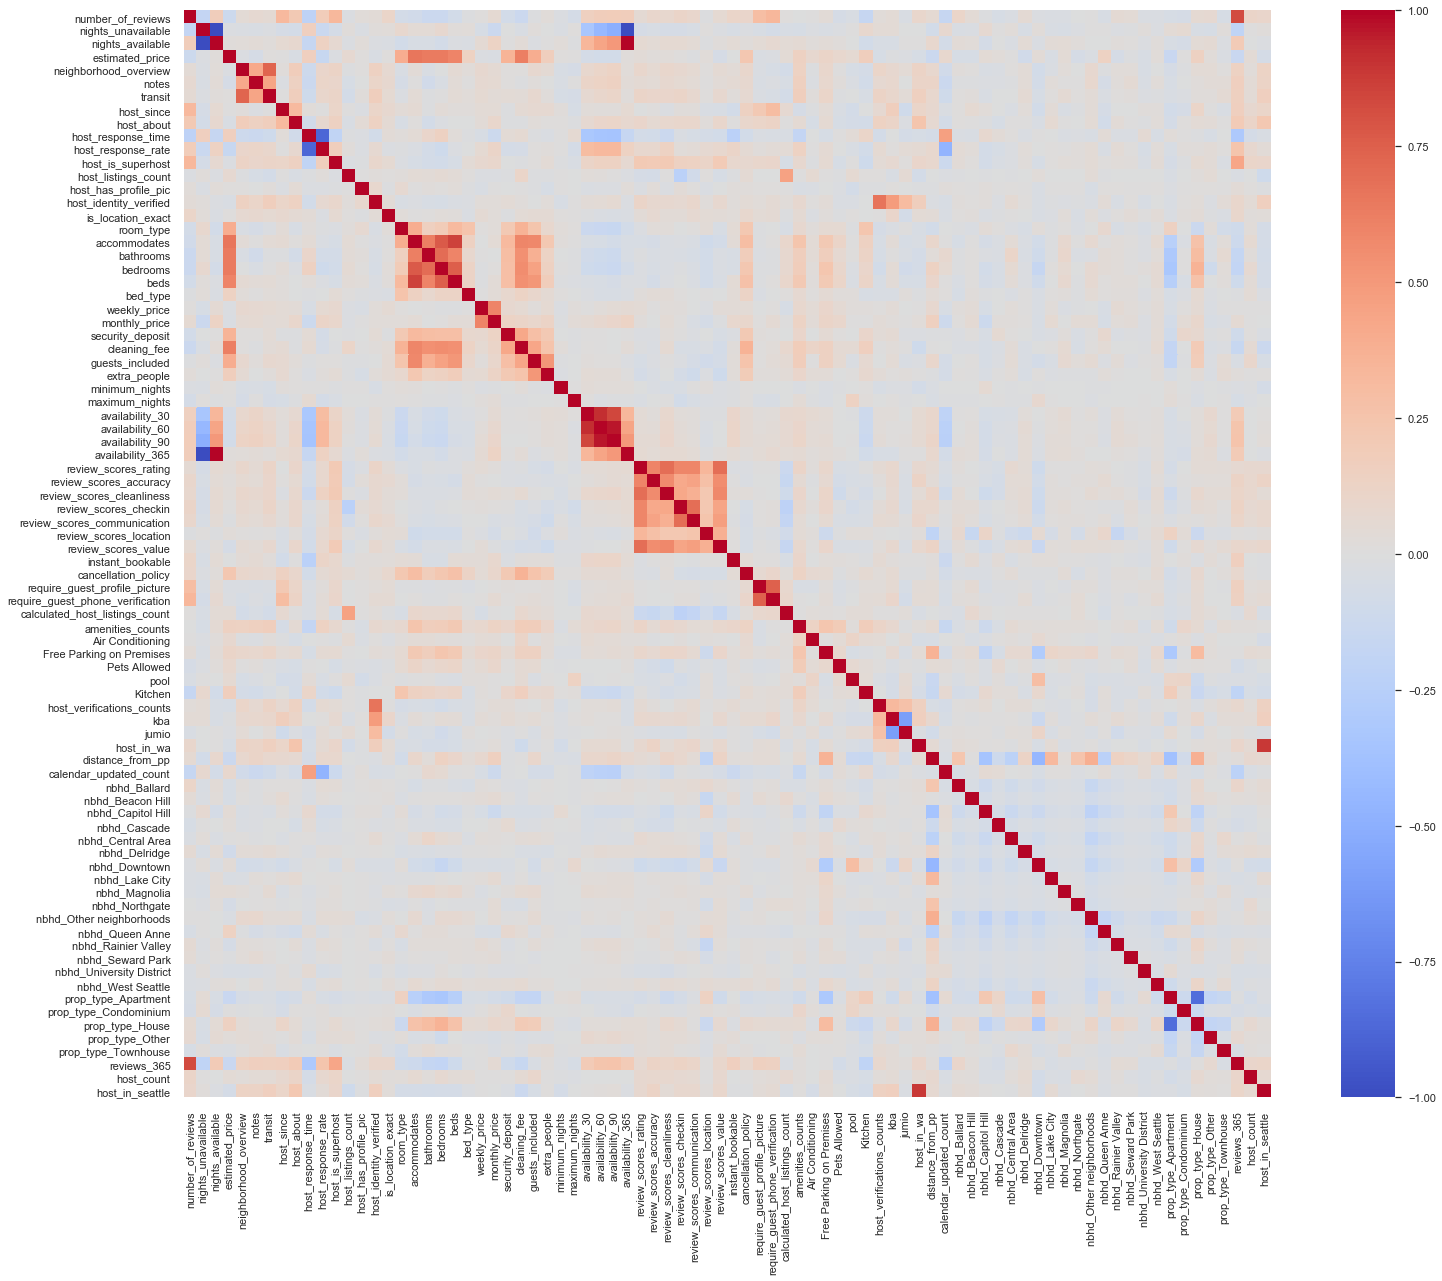

In [339]:
plt.figure(figsize=(25,20))
corrs = one_listing_performance.corr()
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, cmap="coolwarm",annot=False, square = True, fmt = '.2f')
fig = hm.get_figure()

In [340]:
print('The following factors have shown stronger correlations with the number of reviews listings receives:')
selected_1= corrs.reviews_365[(corrs.reviews_365>0.15) | (corrs.reviews_365 <-0.15)]
selected_1[np.abs(selected_1).sort_values(ascending=False).index][2:]

The following factors have shown stronger correlations with the number of reviews listings receives:


host_is_superhost                0.43
host_response_time              -0.31
availability_90                  0.26
host_response_rate               0.25
availability_60                  0.24
calendar_updated_count          -0.22
host_about                       0.20
nights_unavailable              -0.20
availability_365                 0.20
nights_available                 0.20
availability_30                  0.20
Kitchen                         -0.20
bedrooms                        -0.18
bathrooms                       -0.16
instant_bookable                 0.16
notes                            0.16
host_since                       0.16
cleaning_fee                    -0.15
require_guest_profile_picture    0.15
Name: reviews_365, dtype: float64

In [341]:
print('The following factors have shown stronger correlations with the review_scores_rating of listings:')
selected_2= corrs.review_scores_rating[(corrs.review_scores_rating>0.15) | (corrs.review_scores_rating <-0.15)]
selected_2[np.abs(selected_2).sort_values(ascending=False).index][1:]

The following factors have shown stronger correlations with the review_scores_rating of listings:


review_scores_cleanliness     0.69
review_scores_value           0.69
review_scores_accuracy        0.60
review_scores_communication   0.59
review_scores_checkin         0.59
review_scores_location        0.34
host_is_superhost             0.21
Name: review_scores_rating, dtype: float64

Based on the correlations, for someone who is starting to host, it can be beneficial to:
- achieve the superhost status 
- respond to guests fast and often
- update calendar frequently
- introduce herself in the "Host About"/ "Describe yourself" section 
- enable the listing to be [instant bookable](https://www.airbnb.com/help/article/523/what-is-instant-book)
- leave important information in the "notes" section such as how to find the parking spot
- keep hosting and learning as the more experienced hosts also have more reviews
- do not charge the cleaning fee if you could 
- improve the cleanliness 
- set a reasonable price
- accurately describe the listing
- be commutative with guests such as answering their questions and requests 


Some of the tricky suggestions/speculations:
- having kitchen seems to negatively correlated with review received, but the underling factor could actually be superhost status because it turns out listings without kitchen have more superhosts within the group than listings with kitchen. Another assumption is for a big city like Seattle that has great restaurants are everywhere and good transportations, kitchen become less essential to guests compared to other factors. 
- having more than 1 bedrooms also seem to negatively correlated with review received, but the more important factors are that the owners of the listings with more than 1 bedrooms also tend to delay responding to guests and update the calendar less frequently. 
- when a listing requires the guest to have profile picture, it is actually selecting guests who are more likely to leave a reviews because according to [anecdotal experience](https://ourbnb.com/blog/what-percentage-of-guests-leave-a-review/) of some hosts, they usually get no reviews from guests who don't have any profile pictures. 

In [343]:
listings_text = listings_performance[n_l]
listings_text['all_textual_description'] = listings_performance.name + ' ' + listings_performance.summary + ' ' + listings_performance.space + ' ' + listings_performance.description
n_l = np.append(n_l,'all_textual_description')
for col in n_l:
    listings_text[col] = clean_text(listings_text,col)
listings_text['reviews_365'] = listings_performance.reviews_365
listings_text['listing_id'] = listings_performance.listing_id

listings_text.head(5)

,name,summary,space,description,all_textual_description,reviews_365,listing_id
0,cozy studio min to downtown wifi,the cozy studio is a perfect launchpad for you...,hello fellow travelers save some money and hav...,the cozy studio is a perfect launchpad for you...,cozy studio min to downtown wifi the cozy stud...,61,5682
1,downtown convention ctr b&b nice !,great location 98 walk score next to the conve...,greetings from seattle ! thanks for considerin...,great location 98 walk score next to the conve...,downtown convention ctr b&b nice ! great locat...,60,9460
2,the adorable sweet orange craftsman,the sweet orange is a delightful and spacious ...,the sweet orange invites you to stay and play ...,the sweet orange is a delightful and spacious ...,the adorable sweet orange craftsman the sweet ...,15,9531
3,the coolest tangerine dream mil !,welcome to my delicious tangerine dream a colo...,the tangerine dream is a delightful cozy mothe...,welcome to my delicious tangerine dream a colo...,the coolest tangerine dream mil ! welcome to m...,8,9534
4,the down home central and fab !,n/a,the bedroom has a queen temper pedic mattress ...,the bedroom has a queen temper pedic mattress ...,the down home central and fab ! n/a the bedroo...,12,9596


In [344]:
listings_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.8
)
listings_vectors = listings_vectorizer.fit_transform(listings_text.all_textual_description)
rfr = RandomForestRegressor(n_estimators=1000, max_depth=None, random_state=42, n_jobs=-2)
rfr.fit(listings_vectors, listings_text.reviews_365)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-2, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

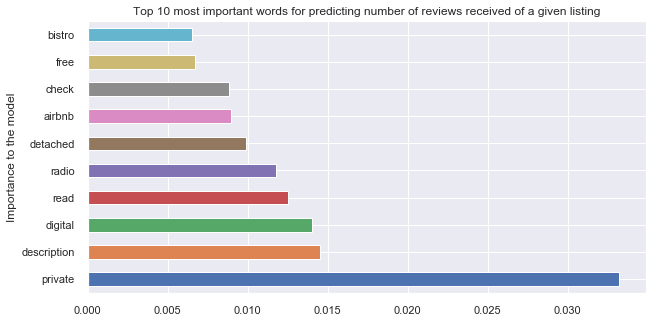

In [346]:
plt.figure(figsize=(10,5))
features = listings_vectorizer.get_feature_names()
importances = rfr.feature_importances_
feat_importances = pd.Series(rfr.feature_importances_[:],index=features[:])
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 most important words for predicting number of reviews received of a given listing')
plt.ylabel('Words')
plt.ylabel('Importance to the model');

In [459]:
print('Listings that include the word "private" in their description have an average reviews of {} in 2015.'.format(
    round(listings_text[listings_text.all_textual_description.str.contains('private',case=False)].reviews_365.mean(),2)
))
print('Those without have an average reviews of {} in 2015.\n'.format(
    round(listings_text[listings_text.all_textual_description.str.contains('private',case=False)==False].reviews_365.mean(),2)
))

Listings that include the word "private" in their description have an average reviews of 22.36 in 2015.
Those without have an average reviews of 15.03 in 2015.



In [456]:
listings_text.all_textual_description.str.extract('(private\s[a-z]+\s[a-z]+)').dropna().sample(15).values

array([['private daylight basement'],
       ['private patio and'],
       ['private room newly'],
       ['private suite experience'],
       ['private garage one'],
       ['private large one'],
       ['private room cozy'],
       ['private quiet and'],
       ['private studio space'],
       ['private space has'],
       ['private room and'],
       ['private roof deck'],
       ['private suite treat'],
       ['private suite in'],
       ['private parking i']], dtype=object)

In [435]:
print('Listings that include the word "free" in their description have an average reviews of {} in 2015 year.'.format(
    round(listings_text[listings_text.all_textual_description.str.contains('free',case=False)].reviews_365.mean(),2)
))
print('Those without have an average reviews of {} in 2015.\n'.format(
    round(listings_text[listings_text.all_textual_description.str.contains('free',case=False)==False].reviews_365.mean(),2)
))

Listings that include the word "free" in their description have an average reviews of 21.6 in 2015 year.
Those without have an average reviews of 16.63 in 2015.



In [460]:
listings_text.all_textual_description.str.extract('([a-z]+\sfree\s[a-z]+\s[a-z]+)').dropna().sample(15).values

array([['a free standing townhouse'],
       ['feel free to ask'],
       ['and free off street'],
       ['of free off street'],
       ['uw free parking on'],
       ['feel free to give'],
       ['balcony free wifi washer'],
       ['following free wi fi'],
       ['feel free asking for'],
       ['of free street parking'],
       ['view free overnight street'],
       ['beach free wifi our'],
       ['of free parking in'],
       ['smoke free and pet'],
       ['pet free fragrance free']], dtype=object)

Based on the keywords' importances to the listing description model, listings the used word "private" seem to also have higher average reviews. The samples of some of these description show that the word was used to point out amenities like private parking, entrance, and so on. It is possible that Airbnb guests in general are more likely to book a listing that mentions some aspects of privacy. In fact, [this study](https://www.bu.edu/bhr/2017/06/07/airbnb-guest-pricing-value/) suggests that guests are willing to pay more for privacy. Booking is the prerequisite of reviewing. Therefore, for our friends who are starting hosting on Aribnb, it can be a good idea to **emphasize about the amenities that would give guests a better sense of privacy.** For instance, even though the guests would have to share the space with the hosts in the houses, do point out the guest suite is private to them might help. 

Additionally, listings the used word "free" seem to also have higher average reviews. The samples of some of these description show that the word was used to point out amenities like free WiFi, parking, movies, and so on. It is possible that  Airbnb guests are more enticed and motivated by freebies to leave a review. For example, [this study](https://priceonomics.com/people-really-like-free-stuff-like-a-lot/) showed that consumers tend to be more attracted to free stuff and not making rational decisions. Therefore, similar to the advise about privacy, new hosts might benefit from **creating a image of good value.** For instance, leaving notes on the countertop about the "free wifi", "free gym", or "free attractions" nearby. 

In [462]:
reviews_text = reviews_imputed[['comments','listing_id']].merge(
    listings_performance[['reviews_365','listing_id']],
    on='listing_id',
    how='inner'
)
reviews_text.comments = clean_text(reviews_text,'comments')
reviews_text.head(2)

,comments,listing_id,reviews_365
0,cute and cozy place perfect location to everyt...,7202016,16
1,kelly has a great room in a very central locat...,7202016,16


In [353]:
reviews_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.8
)
reviews_vectors = reviews_vectorizer.fit_transform(reviews_text.comments)
rfr_2 = RandomForestRegressor(n_estimators=1000, max_depth=None, random_state=42, n_jobs=-2)
rfr_2.fit(reviews_vectors, reviews_text.reviews_365)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-2, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

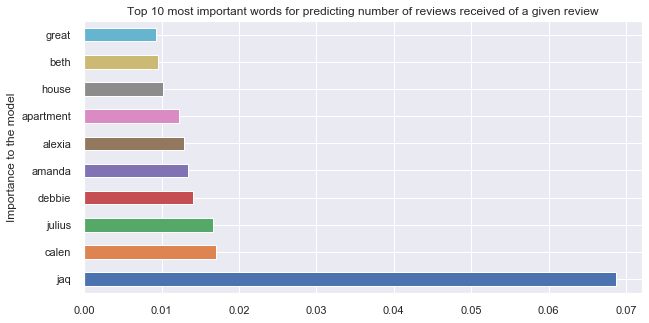

In [354]:
plt.figure(figsize=(10,5))
features_2 = reviews_vectorizer.get_feature_names()
importances_2 = rfr_2.feature_importances_
feat_importances_2 = pd.Series(rfr_2.feature_importances_[:],index=features_2[:])
feat_importances_2.nlargest(10).plot(kind='barh')
plt.title('Top 10 most important words for predicting number of reviews received of a given review')
plt.ylabel('Words')
plt.ylabel('Importance to the model');

In [356]:
print('Reviews that include the word "jaq" has an average reviews of {} in past year.'.format(
    round(reviews_text[reviews_text.comments.str.contains('jaq',case=False)].reviews_365.mean(),2)
))
print('Reviews that did not include the word "jaq" has an average reviews of {} in past year.\n'.format(
    round(reviews_text[reviews_text.comments.str.contains('jaq',case=False)==False].reviews_365.mean(),2)
))


Reviews that include the word "jaq" has an average reviews of 129.49 in past year.
Reviews that did not include the word "jaq" has an average reviews of 42.02 in past year.



In [463]:
reviews_text.comments.str.extract('([a-z]+\sjaq\s[a-z]+\s[a-z]+)').dropna().sample(15).values

array([['and jaq were great'],
       ['meeting jaq and had'],
       ['and jaq s place'],
       ['and jaq but they'],
       ['and jaq for having'],
       ['and jaq but they'],
       ['as jaq and dirk'],
       ['and jaq now exactly'],
       ['and jaq were very'],
       ['and jaq set the'],
       ['and jaq s place'],
       ['recommendations jaq was hard'],
       ['you jaq and dirk'],
       ['downtown jaq was very'],
       ['and jaq and dirk']], dtype=object)

Based on the keywords' importances to the guest review model, the most important word is "jaq", and there are likely 2 reasons to it. First of all, guests love to mention the names of in the reviews, and "jaq" turns out to be the name of 2 very successful co-hosts, "drik and jaq" who owns 3 listings in Seattle. Secondly, the vector is weighted by tf-idf calculation, which weights distinctive words in each reviews heavier. Jaq is a relative unique host name in the datasets, so it gets a higher ranking, which then had more influence on the model. 

Therefore, unfortunately, we wouldn't be able to provide much insights from the review model. In fact, Airbnb reviews are known for positive bias and providing little helpful information to Airbnb and hosts. One Airbnb Data Scientist actually [confirmed about this issue in a Data Summit](https://www.inc.com/laura-montini/the-psychology-of-a-positive-review-according-to-airbnb.html). It seems majority of Airbnb guest wouldn't want to hurt the feeling of the hosts by saying only nice things, which is sweet to hosts but bitter to Data Scientists.   

## Reference

#### Seattle Airbnb Open Data: 
    - https://www.kaggle.com/airbnb/seattle/data

#### First name and gender dataset:
    - https://data.world/howarder/gender-by-name


####  What amenities do guests want the most?
    - https://news.airbnb.com/amenities-do-matter-airbnb-reveals-which-amenities-guests-search-for-most/

#### How many airbnb guests leave review?   
    - https://qr.ae/pNKy4c

#### Definition of co-host
    - https://www.airbnb.com/help/article/1243/whats-a-cohost

#### Definition of  Superhost
    - https://www.airbnb.com/superhost
    
#### Instant booking
    - https://www.airbnb.com/help/article/523/what-is-instant-book

#### Guest profile pictures and leaving reviews
    - https://ourbnb.com/blog/what-percentage-of-guests-leave-a-review/
    
#### Guests paying more for privacy
    - https://www.bu.edu/bhr/2017/06/07/airbnb-guest-pricing-value/

#### People fell for freebies
    - https://priceonomics.com/people-really-like-free-stuff-like-a-lot/
    
#### Airbnb positive reviews bias
    - https://www.inc.com/laura-montini/the-psychology-of-a-positive-review-according-to-airbnb.html
    